# Your interface inside napari

One of the most interesting features of napari, is that it lets you add relatively easily graphical interface elements to the napari viewer. We show here a small example that let's us turn one of the small routines we developed earlier into a small interface that we can then apply to any image.

In [71]:
import napari
from napari.utils import nbscreenshot
import skimage
import numpy as np

from magicgui import magicgui

## magicgui

napari is built on top of the library Qt. One can of course add directly new Qt elements, or widgets, to the viewer, but it requires some knowledge about how Qt works. Instead of this we can use the magicgui library which takes care of a lot of boiler plate for us if we just need a simple to medium complicated interfaces. 

The idea of magicgui is that it takes a function and turns it into an interface with buttons, sliders etc. depending on the inputs and outputs. For example if one of the parameters of the function is an integer, it will create a SpinBox, a field with two buttons to in- decrease the value of the integer.

### Example without napari

magicgui is not tied to napari. We start here by making a tiny guy and we'll see later how this works with napari. This is a simplified version of what you find in the [documentation](https://napari.org/magicgui/usage/quickstart.html). Let's first define a function:

In [47]:
def my_little_function(my_parameter=30):
    
    out = np.sin(my_parameter) ** 2
    return out

Now we turn it into a GUI by passing it to the ```magicgui``` function. We also pass an additional parameter here called ```call_button``` to change the name of the button that executes the function:

In [48]:
my_little_function = magicgui(my_little_function, call_button="calculate")

Now we can visualize our interface (it will appear as a separate window):

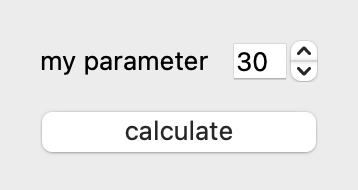

In [49]:
my_little_function.show()

Now we can execute our function as a normal function, using the default value or a new one:

In [50]:
my_little_function()

0.9762064902075782

In [51]:
my_little_function(my_parameter=2)

0.826821810431806

But we can also change the value in the interface and then execute the function:

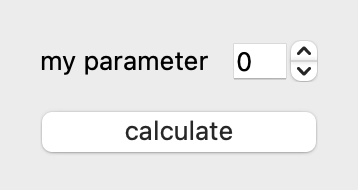

In [53]:
my_little_function.show()

In [54]:
my_little_function()

0.0

So the interface allows us to control the value of ```my_parameter```!

### Decorator

Note that in many cases you won't see the line:
```python
my_little_function = magicgui(my_little_function, call_button="calculate")
```

but rather this:
```python
@magicgui(call_button="calculate")
def my_little_function(my_parameter=30):
    
    out = np.sin(my_parameter) ** 2
    return out
```

This way of using the ```magicgui``` function is called a decorator. It's a short notation for what we did above but works entirely the same way!

### Connecting

For the moment we haven't used the ```calculate``` button. It does execute the function when we press on it, but nothing else really happens: we can't recover the calculation. For that we need to add a **callback** the the button, i.e. we need to link the button with a function that gets executed when it's pressed. Also the function takes as input the output of the function executed by the button:

In [55]:
def my_callback(value):
    
    print(f"Your function was called! The result is: {value}")

In [56]:
my_little_function.called.connect(my_callback)

<function __main__.my_callback(value)>

In [57]:
my_little_function.show();

Your function was called! The result is: 0.0


## napari and magicgui

The logic with napari is very similar. We just have to know what inputs/outputs are allowed and we need to add the interface to napari. We define a tiny workflow that simply computer a mask:

In [62]:
def workflow(image):
    im_th = image > skimage.filters.threshold_li(image)
    im_th = skimage.measure.label(im_th)
    return im_th

If we just turn this function into a gui, napari will not know what it's supposed to do with the inputs and outputs. For example, we create here a labelled image: when we press ```calculate``` we want the output to be added as a ```Label``` layer and not an ```Image``` layer. We thus have to give a **hint** to napari. For that we specify the expected type of input/output. We can import these types from napari:

In [74]:
from napari.layers import Image
from napari.types import ImageData

and then use them in our function definition:

In [83]:
@magicgui(call_button="execute", layout="vertical")
def workflow(layer_image: Image) -> ImageData:
    im_th = layer_image.data > skimage.filters.threshold_li(layer_image.data)
    im_th = skimage.measure.label(im_th)
    return im_th

Now we say that the input should be a napari layer (from which we grab then the ```data```, and the output should be an Image. The last thing we have to learn: how to add the interface to napari? This is very simple: once we have a ```viewer``` we can just use ```viewer.window.add_dock_widget```:

In [84]:
image = skimage.io.imread('../data/cellaltlas/19838_1252_F8_1.tiff')

In [85]:
viewer = napari.Viewer()
viewer.add_image(image, channel_axis=2)
viewer.window.add_dock_widget(workflow, area="right")

/Users/gw18g940/mambaforge/envs/micpy/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


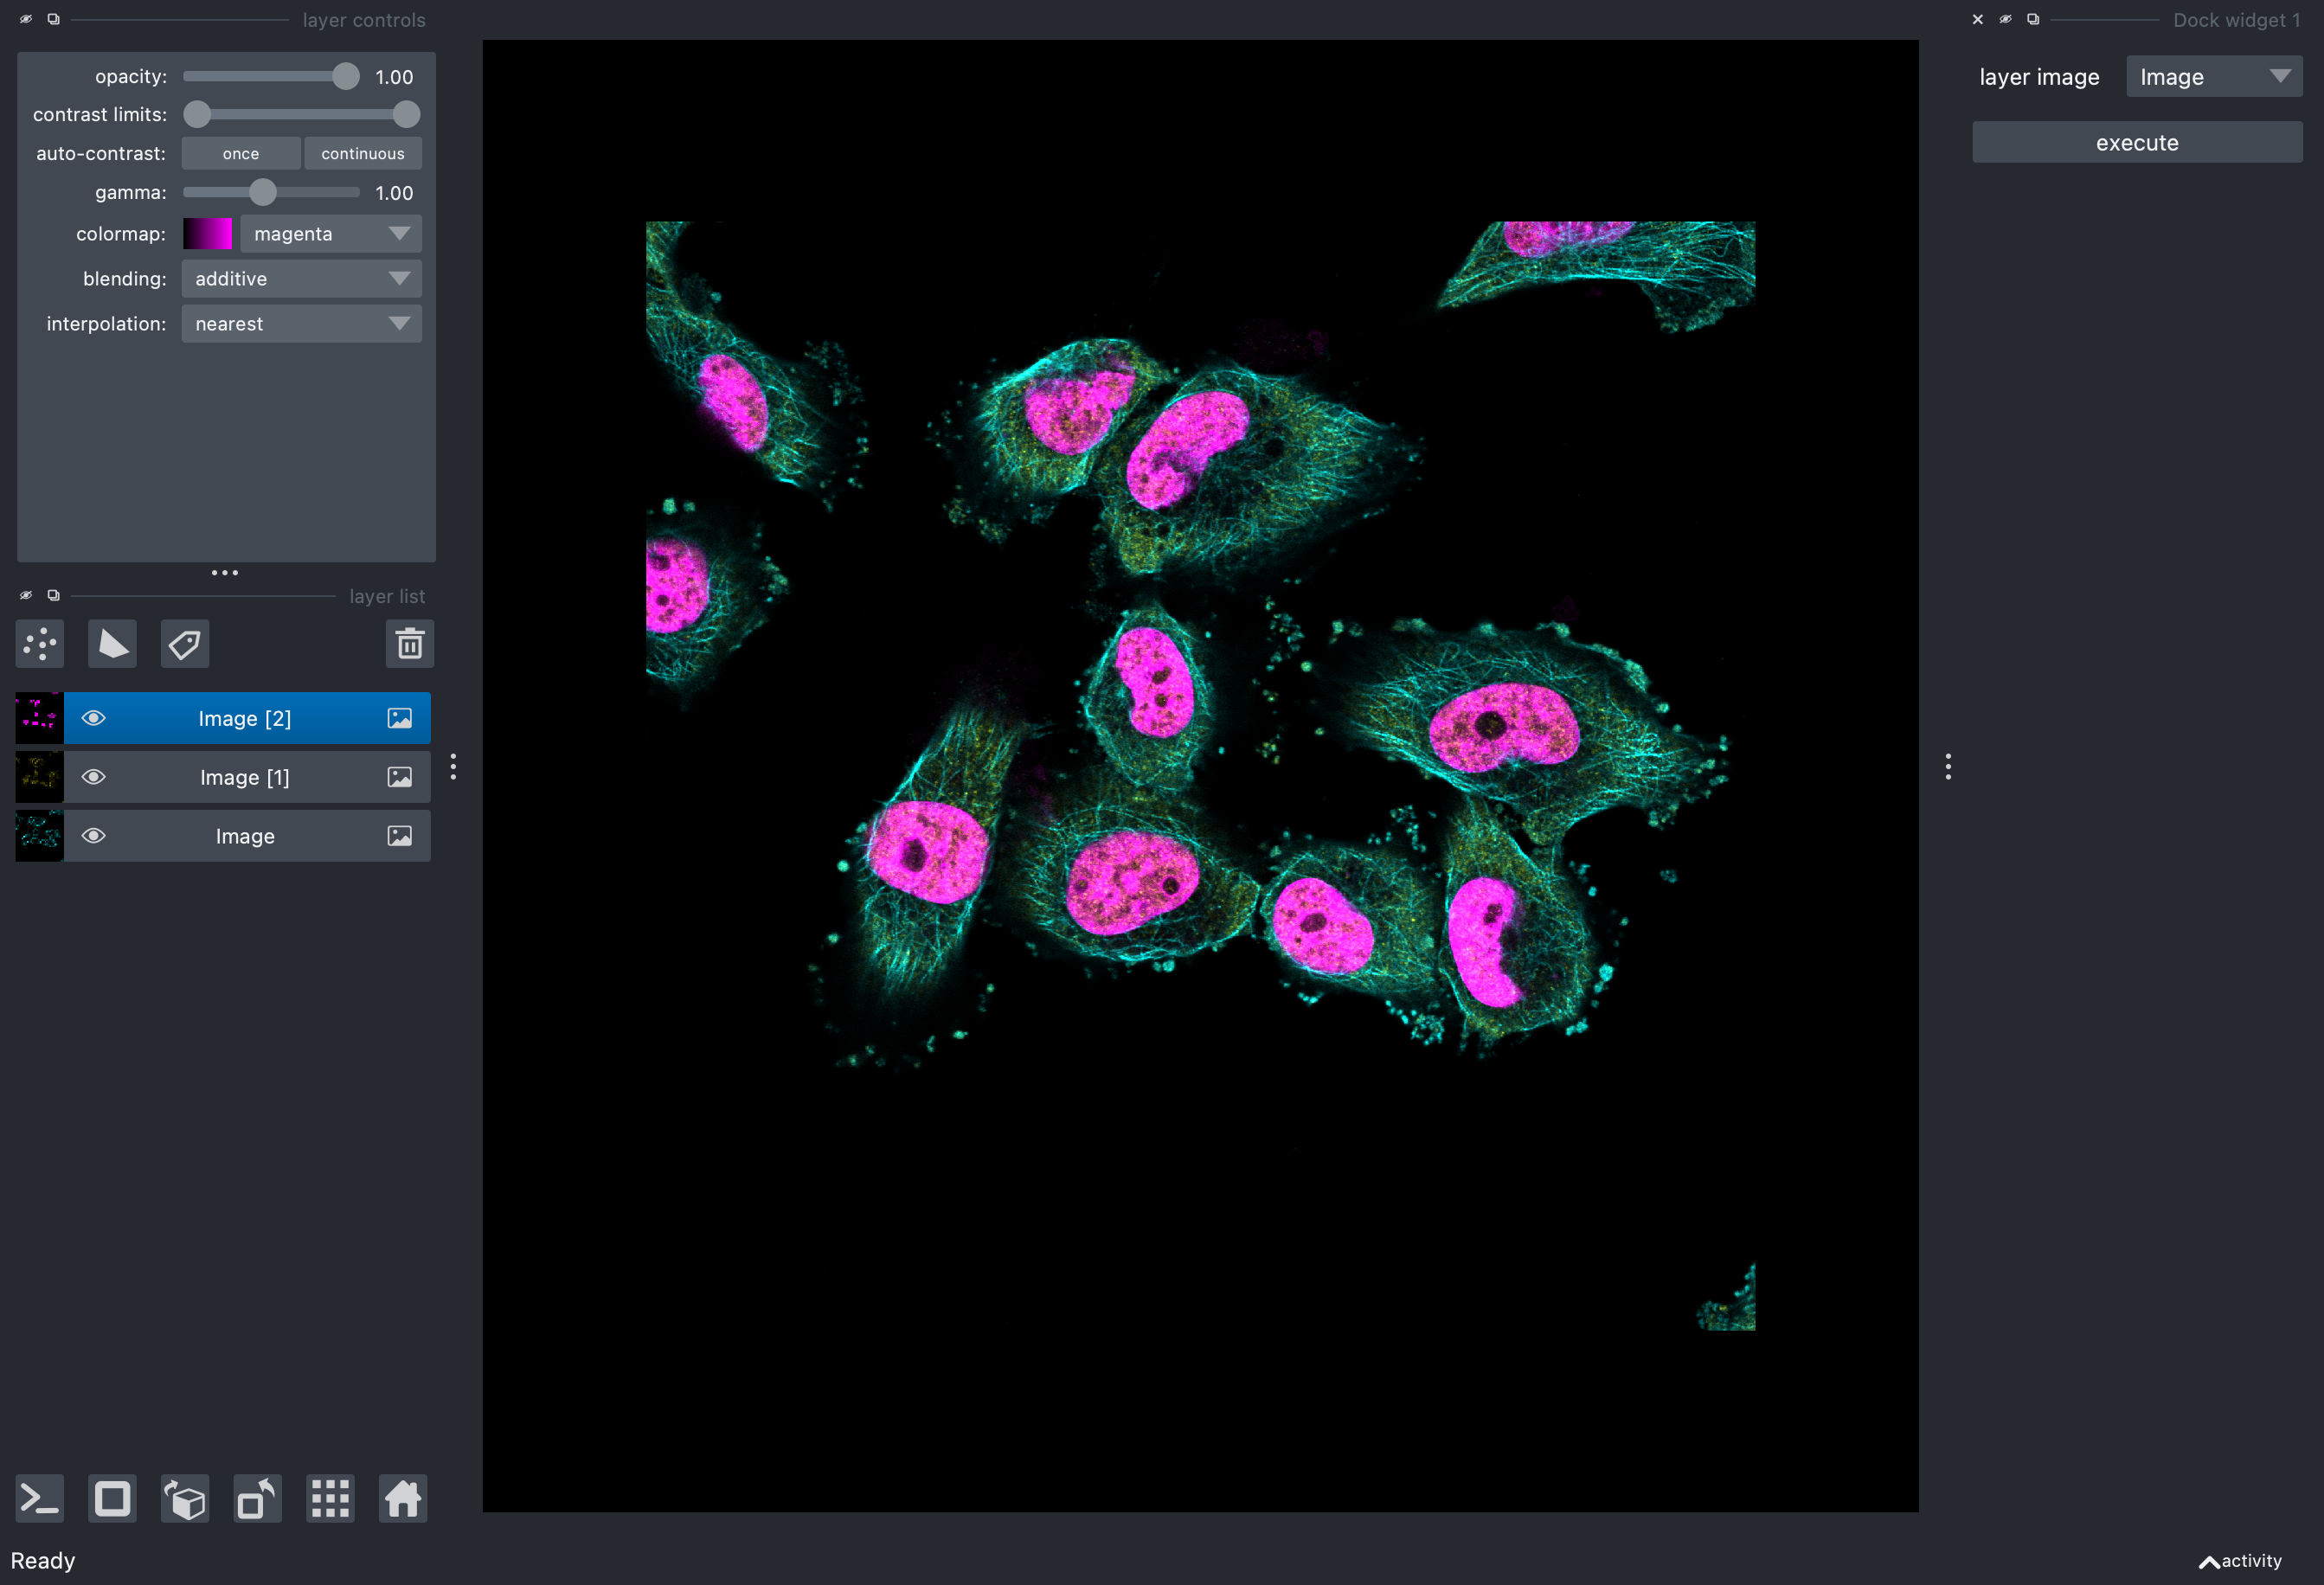

In [86]:
nbscreenshot(viewer)

Now we can pick a layer (note that the list is made for us) and click on the button:

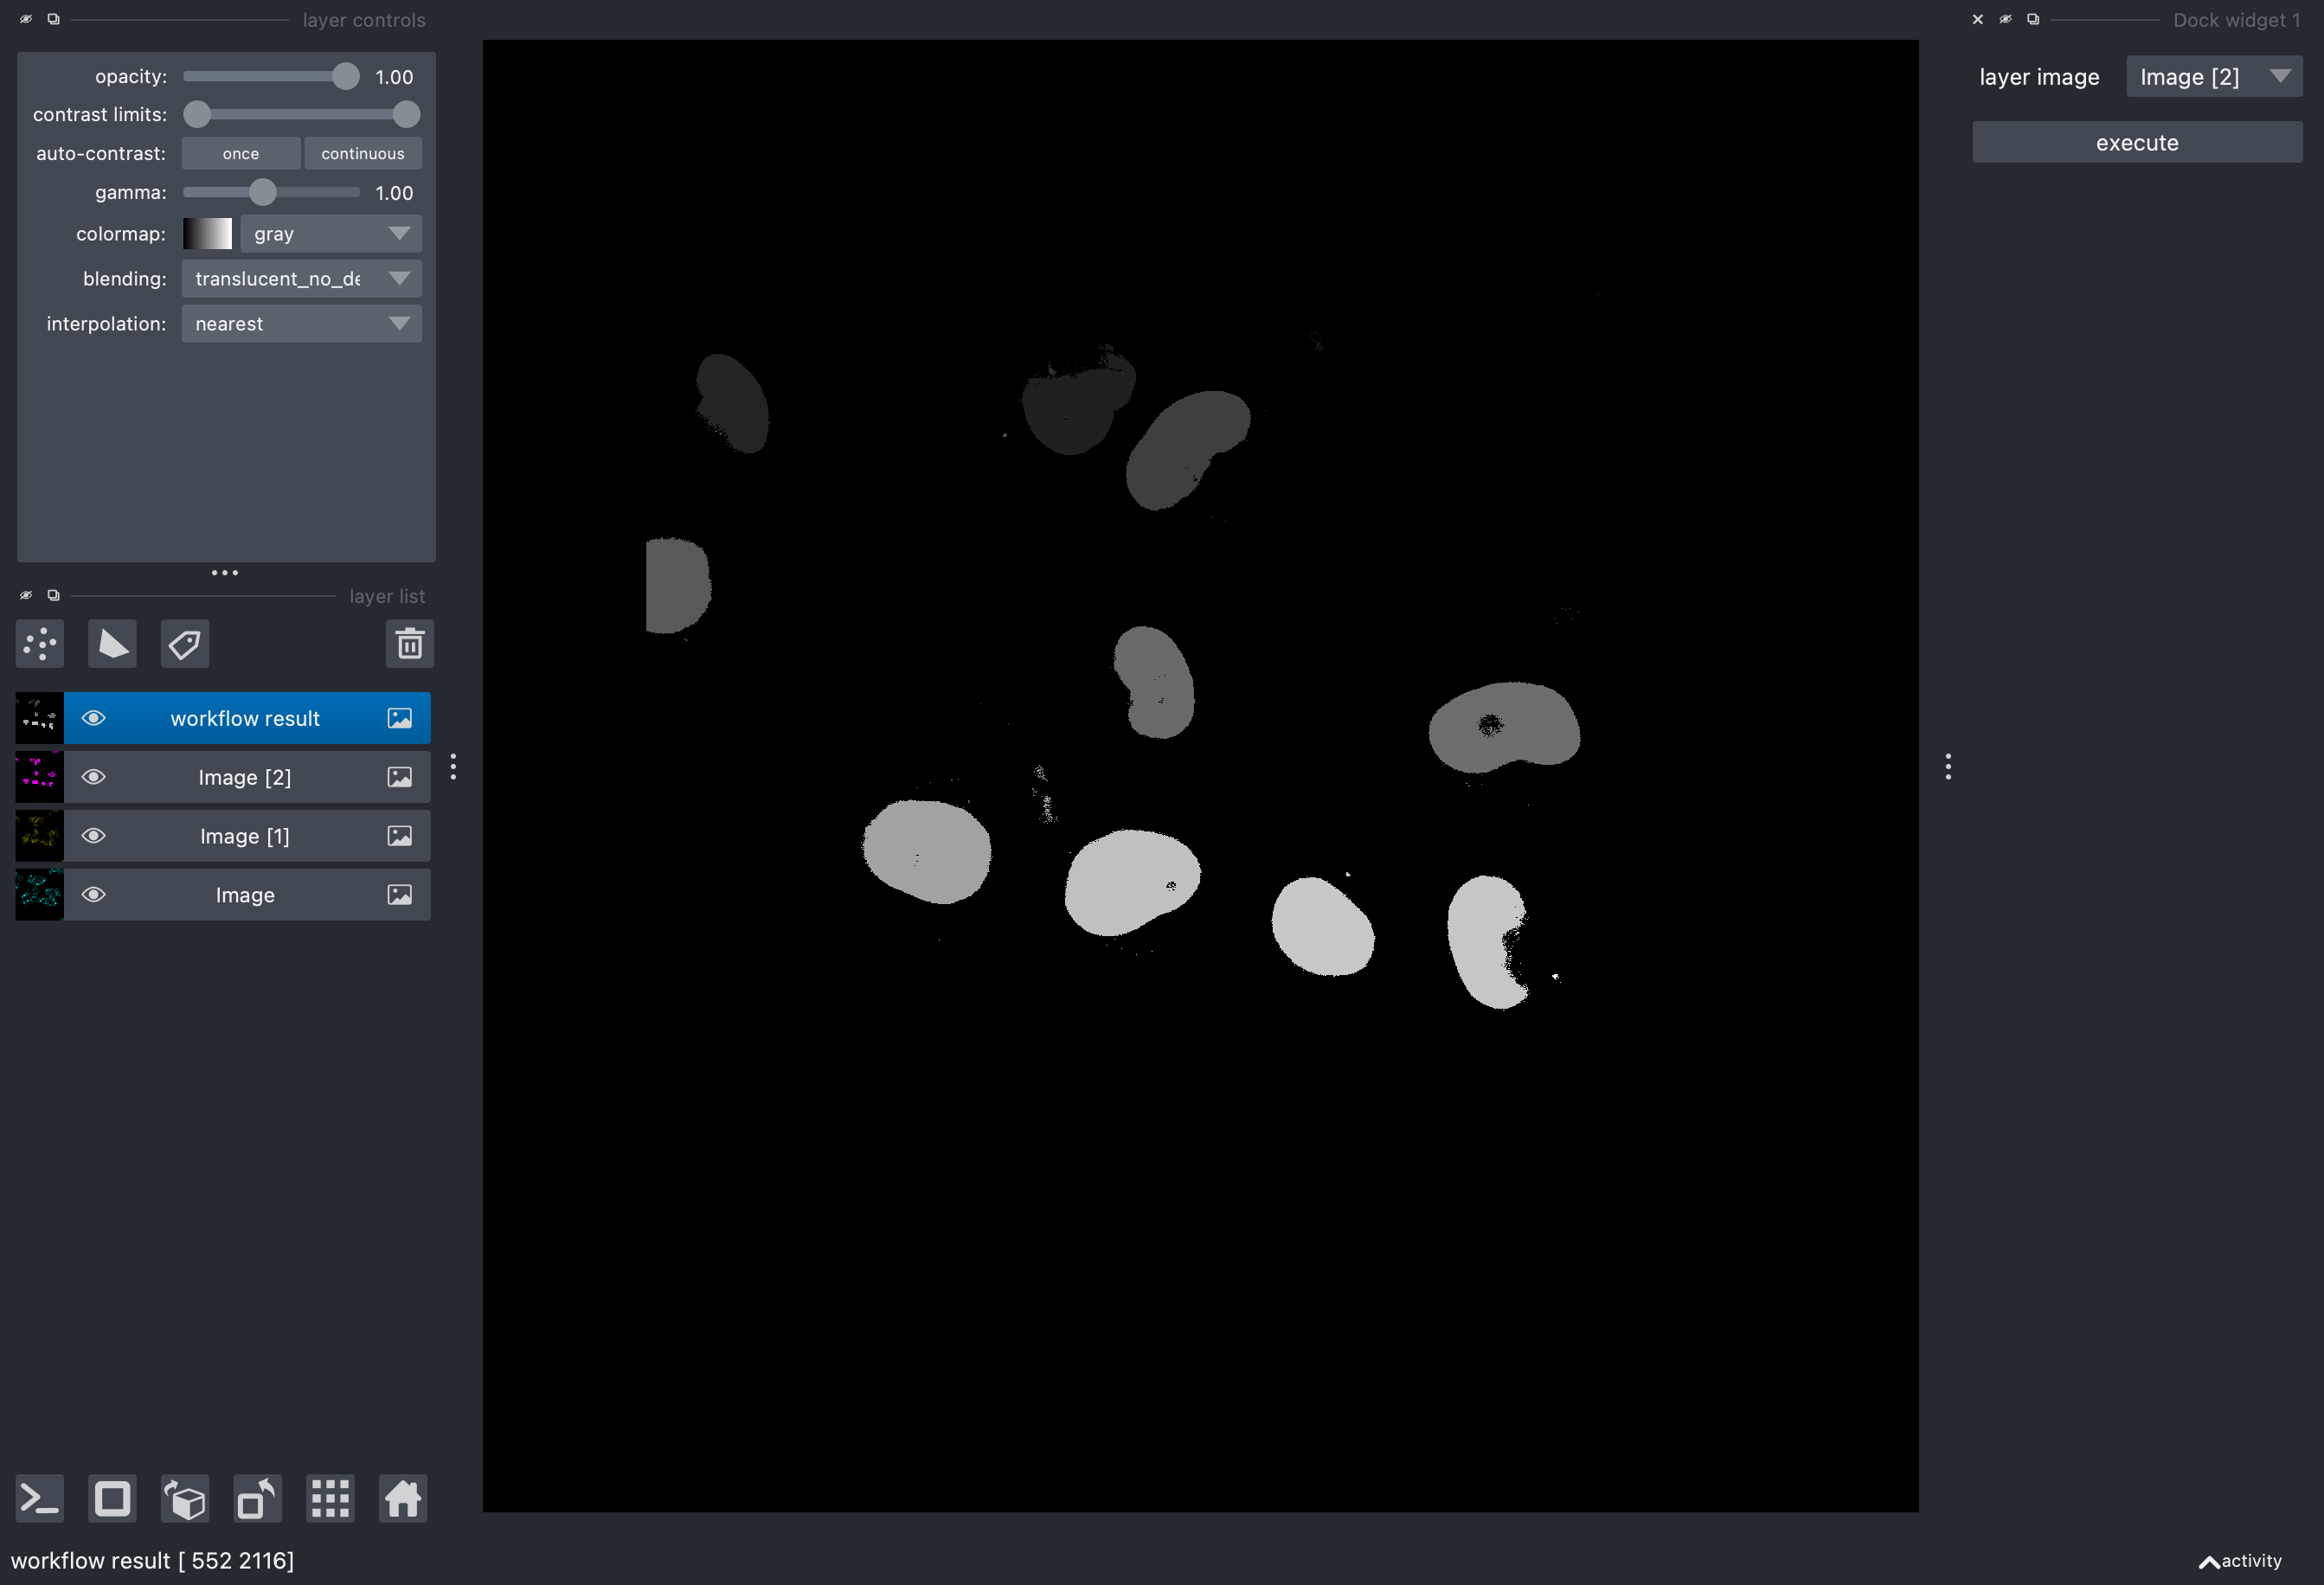

In [87]:
nbscreenshot(viewer)

Great the output has been added to the viewer. The only error we made, was to say that the output was an ```ImageData``` while here, we clearly need labels. We can fix this by importing the ```LabelsData``` type:

In [88]:
from napari.types import ImageData, LabelsData

@magicgui(call_button="execute", layout="vertical")
def workflow(layer_image: Image) -> LabelsData:
    im_th = layer_image.data > skimage.filters.threshold_li(layer_image.data)
    im_th = skimage.measure.label(im_th)
    return im_th

In [92]:
viewer = napari.Viewer()
viewer.add_image(image, channel_axis=2)
viewer.window.add_dock_widget(workflow, area="right")

/Users/gw18g940/mambaforge/envs/micpy/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


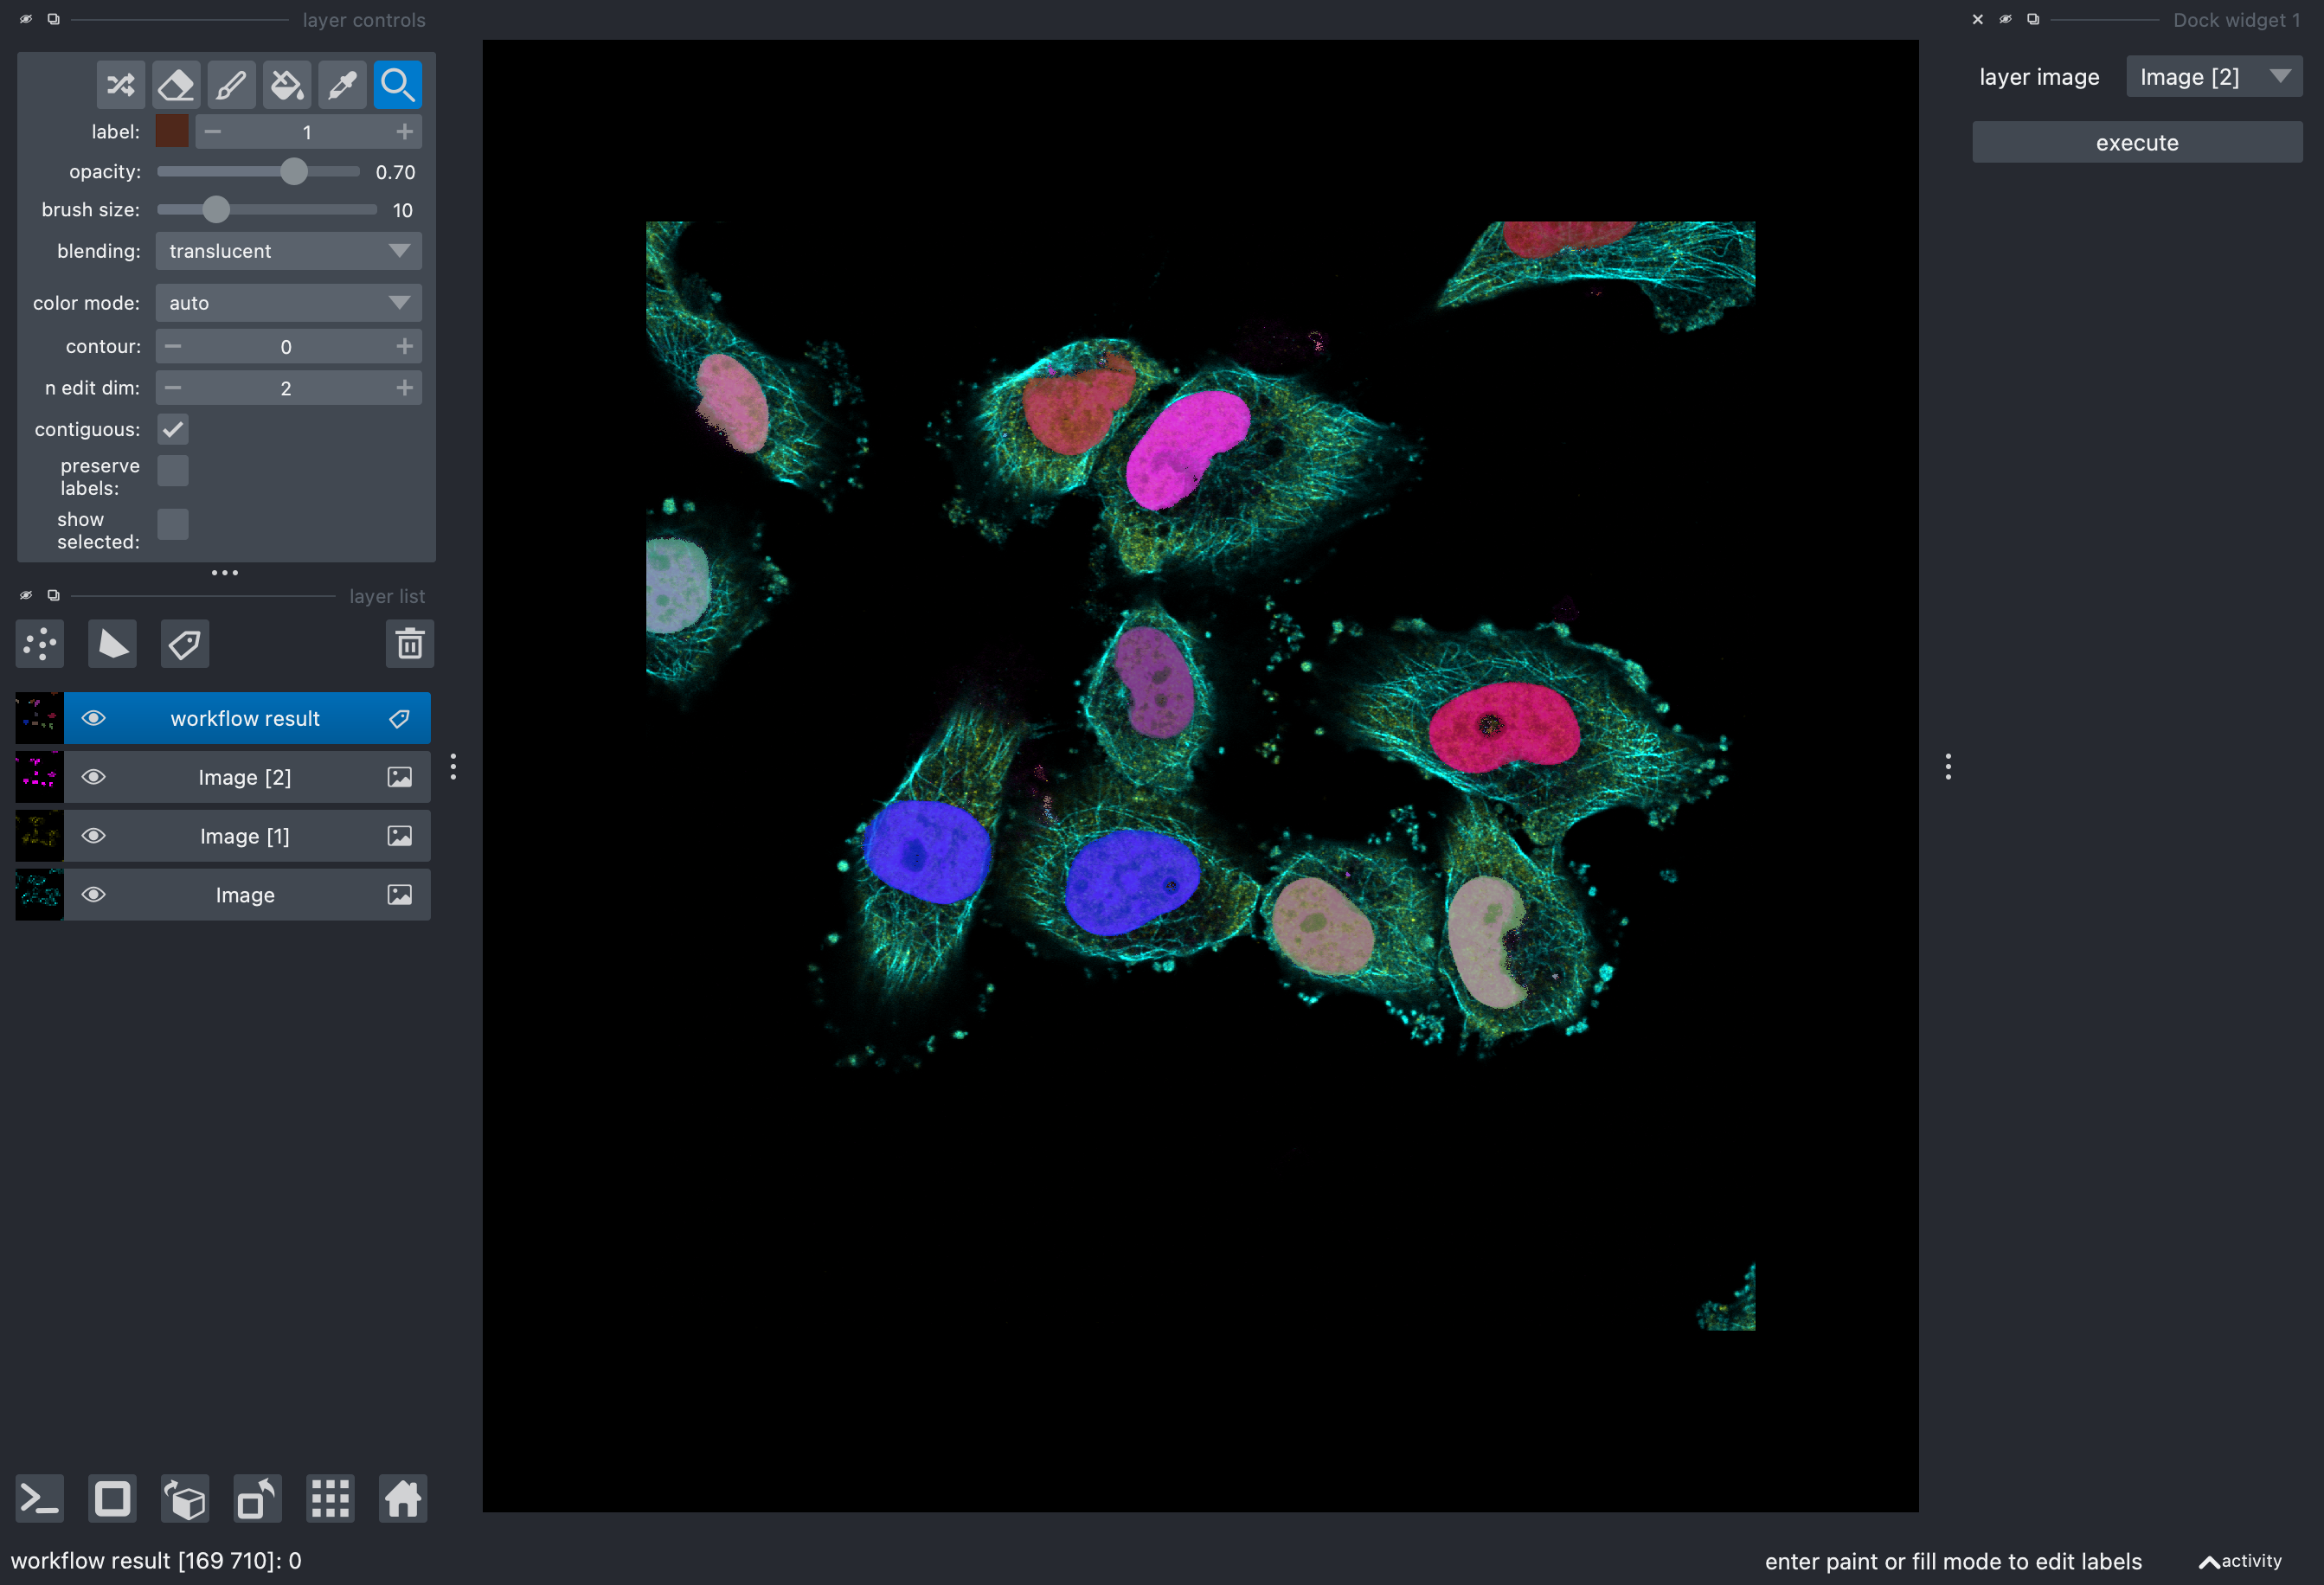

In [90]:
nbscreenshot(viewer)

## Exercise

Adapt the function above so that it takes two layers, performs thresholding on both and returns the logical OR combination of the two masks:

In [96]:
from napari.types import ImageData, LabelsData
import napari
import numpy as np
imoprt skimage


@magicgui(call_button="execute", layout="vertical")
def workflow(layer_image: Image, layer_image2: Image) -> LabelsData:
    im_th = layer_image.data > skimage.filters.threshold_li(layer_image.data)
    im_th2 = layer_image2.data > skimage.filters.threshold_li(layer_image2.data)
    
    combined = np.logical_or(im_th, im_th2)
    
    return combined

In [97]:
image = skimage.io.imread('../data/cellaltlas/19838_1252_F8_1.tiff')

In [98]:
viewer = napari.Viewer()
viewer.add_image(image, channel_axis=2)
viewer.window.add_dock_widget(workflow, area="right")

/Users/gw18g940/mambaforge/envs/micpy/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
